# Load packages

In [20]:
import xarray as xr
import torch
import plotly.express as px
from torchvision.io import write_png
import torch.nn as nn

# Torch cuda check

In [21]:
print(torch.__version__)
# Cuda 12.1

2.1.0+cu121


In [22]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.mem_get_info()

(4135518208, 25385107456)

# Load data

In [23]:
bm_xr = xr.load_dataset("~/data/nsidc/BedMachineAntarctica-v3.nc")

In [33]:
# Function: converts from [0, 765] to {r, g, b} however some are not valid to convert back

def cont_765_to_rgb(input):
    # input: torch.Size([2450, 1, 60, 60])
    # 0 - 255:
    red = torch.where(condition = input < (255), input = input.int(), other = 255)
    # 255 - 510:
    green = torch.where(condition = (input > (255)), input = input.int() - 255, other = 0) # subtract 255
    green = torch.where(condition = green < 255, input = green.int(), other = 255)
    # 510 - 765:
    blue = torch.where(condition = input > (255*2), input = (input - (255*2)).int(), other = 0)

    rgb = torch.cat([red, green, blue], dim = 1)
    
    return(rgb.type(torch.uint8))

In [15]:
def export_train_images(bm_xr, d_y_min, d_y_max, d_x_min, d_x_max):

    train_bm_xr = bm_xr.sel(x = slice(d_x_min, d_x_max), 
                            y = slice(d_y_max, d_y_min))
    # Print to check dims
    print(train_bm_xr)

    train_tensor = torch.tensor(train_bm_xr.bed.values).unsqueeze(0)

    IMAGE_DIM = 60
    N_ROW_IMAGES = int(val_bm_xr.bed.values.shape[0]/IMAGE_DIM)
    N_COLUMN_IMAGES = int(val_bm_xr.bed.values.shape[1]/IMAGE_DIM)

    image_tensor = torch.empty(size = (0, 1, IMAGE_DIM, IMAGE_DIM))

    for row in range(0, N_ROW_IMAGES):
        row_min = row * IMAGE_DIM
        row_max = row_min + IMAGE_DIM

        for column in range(0, N_COLUMN_IMAGES):
            column_min = column * IMAGE_DIM
            column_max = column_min + IMAGE_DIM

            image_tensor = torch.cat((image_tensor, train_tensor[:, row_min : row_max, column_min : column_max].unsqueeze(0)), dim = 0)

    min_values, _ = torch.min(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    max_values, _ = torch.max(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    range_values = max_values - min_values

    norm = torch.subtract(input = image_tensor.reshape(image_tensor.shape[0], -1), other = min_values.unsqueeze(1))
    norm = torch.div(input = norm, other = range_values.unsqueeze(1))
    norm = norm.reshape(image_tensor.shape)
    cont_765 = norm * (3*255)

    # Low qual
    pool = nn.AvgPool2d(4, stride = 4)
    cont_765_lq = pool(cont_765)
    
    rgb = cont_765_to_rgb(cont_765)
    rgb_lq = cont_765_to_rgb(cont_765_lq)

    n_images = rgb.shape[0]

    for i in range(n_images):
        # Create filename: string with contant length
        number = str(i)
        while(len(number) < 4):
            number = '0' + number

        name_hr = "datasets/ANT_train/ANT_train_HR_sub/" + number + ".png"
        #name_lr = "datasets/ANT_train/ANT_train_LR_sub/X4_sub/" + number + "x4" + ".png"
        name_lr = "datasets/ANT_train/ANT_train_LR_sub/X4_sub/" + number + ".png"

        # following https://data.vision.ee.ethz.ch/cvl/DIV2K/
        write_png(rgb[i, :, :, :].type(torch.uint8), filename = name_hr)
        write_png(rgb_lq[i, :, :, :].type(torch.uint8), filename = name_lr)

<xarray.Dataset>
Dimensions:    (x: 2100, y: 4200)
Coordinates:
  * x          (x) int32 -200000 -199500 -199000 ... 848500 849000 849500
  * y          (y) int32 1799500 1799000 1798500 ... -299000 -299500 -300000
Data variables:
    mapping    |S1 b''
    mask       (y, x) int8 2 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
    firn       (y, x) float32 18.97 18.98 19.0 19.01 ... 29.95 29.94 29.94 29.93
    surface    (y, x) float32 1.945e+03 1.945e+03 ... 3.284e+03 3.283e+03
    thickness  (y, x) float32 1.75e+03 1.755e+03 ... 2.586e+03 2.578e+03
    bed        (y, x) float32 194.9 190.7 188.6 188.9 ... 704.5 697.6 705.3
    errbed     (y, x) float32 34.0 32.0 30.0 30.0 30.0 ... 35.0 35.0 35.0 35.0
    source     (y, x) int8 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5 5 5
    dataid     (y, x) int8 0 2 0 0 0 0 2 2 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    geoid      (y, x) int16 12 12 12 12 12 12 12 ... -23 -23 -23 -23 -23 -23 -23
Attributes: (12/17)
    Conventions:   

In [14]:
train_y_max = 1800000 - 500 # 1900 km, -500 for midpoints
train_y_min = -300000 # - 300 km

train_x_max = 850000 - 500 # 900 km
train_x_min = -200000 # - 200 km

y_range = train_y_max - train_y_min
x_range = train_x_max - train_x_min

print("Y range in km", y_range/1000)
print("X range in km", x_range/1000)

# 2450 training images
(train_x_max - train_x_min + 500) * (train_y_max - train_y_min + 500) / 900000

# export_train_images(bm_xr, train_y_min, train_y_max, train_x_min, train_x_max)

Y range in km 2099.5
X range in km 1049.5


2450000.0

# Repeat for Validation data

In [17]:
val_y_max = 1800000 - 500# 1900 km
val_y_min = -300000 # - 300 km

val_x_max = 910000 - 500 # 900 km
val_x_min = 850000 # - 200 km

val_y_range = val_y_max - val_y_min
val_x_range = val_x_max - val_x_min

print("Y range in km", val_y_range/1000)
print("X range in km", val_x_range/1000)

# 138 training images
(val_x_max - val_x_min + 500) * (val_y_max - val_y_min + 500) / 900000

Y range in km 2099.5
X range in km 59.5


140000.0

In [8]:
def make_val_data(bm_xr, d_y_min, d_y_max, d_x_min, d_x_max):

    val_bm_xr = bm_xr.sel(x = slice(d_x_min, d_x_max), 
                            y = slice(d_y_max, d_y_min))
    # Print to check dims
    print(val_bm_xr)

    train_tensor = torch.tensor(val_bm_xr.bed.values).unsqueeze(0)

    IMAGE_DIM = 60
    N_ROW_IMAGES = int(val_bm_xr.bed.values.shape[0]/IMAGE_DIM)
    N_COLUMN_IMAGES = int(train_bm_xr.bed.values.shape[1]/IMAGE_DIM)

    image_tensor = torch.empty(size = (0, 1, IMAGE_DIM, IMAGE_DIM))

    for row in range(0, N_ROW_IMAGES):
        row_min = row * IMAGE_DIM
        row_max = row_min + IMAGE_DIM

        for column in range(0, N_COLUMN_IMAGES):
            column_min = column * IMAGE_DIM
            column_max = column_min + IMAGE_DIM

            image_tensor = torch.cat((image_tensor, train_tensor[:, row_min : row_max, column_min : column_max].unsqueeze(0)), dim = 0)

    min_values, _ = torch.min(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    max_values, _ = torch.max(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    range_values = max_values - min_values

    norm = torch.subtract(input = image_tensor.reshape(image_tensor.shape[0], -1), other = min_values.unsqueeze(1))
    norm = torch.div(input = norm, other = range_values.unsqueeze(1))
    norm = norm.reshape(image_tensor.shape)
    cont_765 = norm * (3*255)

    # Low qual
    pool = nn.AvgPool2d(4, stride = 4)
    cont_765_lq = pool(cont_765)
    
    rgb = cont_765_to_rgb(cont_765)
    rgb_lq = cont_765_to_rgb(cont_765_lq)

    n_images = rgb.shape[0]

    for i in range(n_images):
        # Create filename: string with contant length
        number = str(i)
        while(len(number) < 4):
            number = '0' + number

        name_hr = "datasets/ANT_val/ANT_val_HR_sub/" + number + ".png"
        # name_lr = "datasets/ANT_val/ANT_val_LR_sub/X4_sub/" + number + "x4" + ".png"
        name_lr = "datasets/ANT_val/ANT_val_LR_sub/X4_sub/" + number + ".png"

        # following https://data.vision.ee.ethz.ch/cvl/DIV2K/
        write_png(rgb[i, :, :, :].type(torch.uint8), filename = name_hr)
        write_png(rgb_lq[i, :, :, :].type(torch.uint8), filename = name_lr)
    
make_val_data(bm_xr, val_y_min, val_y_max, val_x_min, val_x_max)

<xarray.Dataset>
Dimensions:    (x: 120, y: 4200)
Coordinates:
  * x          (x) int32 850000 850500 851000 851500 ... 908500 909000 909500
  * y          (y) int32 1799500 1799000 1798500 ... -299000 -299500 -300000
Data variables:
    mapping    |S1 b''
    mask       (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
    firn       (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 29.91 29.92 29.92 29.93
    surface    (y, x) float32 1.298e+03 1.361e+03 ... 3.321e+03 3.321e+03
    thickness  (y, x) float32 0.0 0.0 0.0 0.0 ... 2.61e+03 2.616e+03 2.622e+03
    bed        (y, x) float32 1.298e+03 1.361e+03 1.304e+03 ... 705.2 699.1
    errbed     (y, x) float32 10.0 10.0 10.0 10.0 ... 182.0 192.0 202.0 212.0
    source     (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 3 ... 5 5 5 5 5 5 5 5 5 5 5 5
    dataid     (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    geoid      (y, x) int16 17 17 17 17 17 17 17 ... -22 -22 -22 -22 -22 -22 -22
Attributes: (12/17)
    Convention

# Repeat for 256x256 images

In [14]:
print("A 256 x 256 px image has", 256*256,"pixels.")
print("A 256px where each pixel = 500 m corresponds to a height/width per image of", 256*500,"meters.") # 128 km
print("The area represented thus is", (256*500)**2/1000,"km^2.") # 16

A 256 x 256 px image has 65536 pixels.
A 256px where each pixel = 500 m corresponds to a height/width per image of 128000 meters.
The area represented thus is 16384000.0 km^2.


In [1]:
import matplotlib.pyplot as plt  # plotting library
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines
import matplotlib.patches as mpatches # draw domain boundry patches

def domain_vis(y_min, y_max, x_min, x_max, special_colour = '#2468DB'):
    # Set font
    hfont = {'fontname':'Helvetica'}
    special_color = '#2468DB'

    # Initialise plot
    #fig = plt.figure(figsize = [10, 10])
    fig = plt.figure()
    ax = plt.axes(projection = ccrs.SouthPolarStereo())

    # restrict to over 65 lat
    ax.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())

    # hides boundry line
    ax.axis('off')

    # add grey land
    ax.add_feature(cfeature.LAND, facecolor = ("#FAFAFA"), alpha = 1.0)

    # thin coastline lines
    ax.add_feature(cfeature.COASTLINE, edgecolor = special_color, linestyle = '-', linewidth = 1.5, alpha = 0.7)

    # Add patch
    ax.add_patch(mpatches.Rectangle(xy = [x_min, y_min], width = (x_max - x_min), height = (y_max - y_min),
                                    facecolor = 'none', edgecolor = special_color, linewidth = 3.0,
                                    transform = ccrs.SouthPolarStereo()))

    # Add South Pole marker
    ax.scatter(0, 0, 
            color = "grey", marker = "x", s = 80,
            transform = ccrs.SouthPolarStereo())

    # Add Dome A marker
    ax.scatter(1023593.357129, 229738.290579, 
            color = special_color, marker = "x", s = 80,
                            transform = ccrs.SouthPolarStereo())

    plt.show()

In [19]:
train256_y_min = -500000 
train256_y_max = 2060000 - 500 # 2060 km, -500 for midpoints
# train256_y_min + 20 * 256 * 500

train256_x_min = -500000 
train256_x_max = 780000 - 500 
# train256_x_min + 10 * 256 * 500

y_range = train256_y_max - train256_y_min
x_range = train256_x_max - train256_x_min

print("Y range in km", y_range/1000)
print("X range in km", x_range/1000)

# 200 training images
(train256_x_max - train256_x_min + 500) * (train256_y_max - train256_y_min + 500) / (256*256)

Y range in km 2559.5
X range in km 1279.5


50000000.0

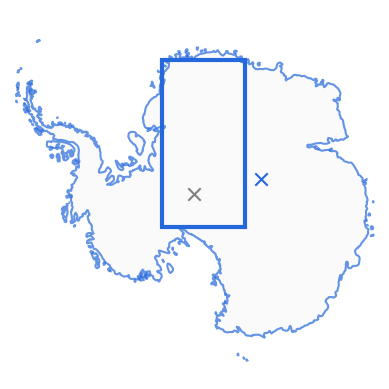

In [34]:
domain_vis(train256_y_min, train256_y_max, train256_x_min, train256_x_max)

In [35]:
def export_train256_images(bm_xr, d_y_min, d_y_max, d_x_min, d_x_max):

    train_bm_xr = bm_xr.sel(x = slice(d_x_min, d_x_max), 
                            y = slice(d_y_max, d_y_min))
    # Print to check dims
    print("Dimensions", train_bm_xr.dims)

    train_tensor = torch.tensor(train_bm_xr.bed.values).unsqueeze(0)

    IMAGE_DIM = 256
    N_ROW_IMAGES = int(train_bm_xr.bed.values.shape[0]/IMAGE_DIM)
    N_COLUMN_IMAGES = int(train_bm_xr.bed.values.shape[1]/IMAGE_DIM)

    image_tensor = torch.empty(size = (0, 1, IMAGE_DIM, IMAGE_DIM))

    for row in range(0, N_ROW_IMAGES):
        row_min = row * IMAGE_DIM
        row_max = row_min + IMAGE_DIM

        for column in range(0, N_COLUMN_IMAGES):
            column_min = column * IMAGE_DIM
            column_max = column_min + IMAGE_DIM

            image_tensor = torch.cat((image_tensor, train_tensor[:, row_min : row_max, column_min : column_max].unsqueeze(0)), dim = 0)

    min_values, _ = torch.min(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    max_values, _ = torch.max(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    range_values = max_values - min_values

    norm = torch.subtract(input = image_tensor.reshape(image_tensor.shape[0], -1), other = min_values.unsqueeze(1))
    norm = torch.div(input = norm, other = range_values.unsqueeze(1))
    norm = norm.reshape(image_tensor.shape)
    # Continuous and discretised to 755
    cont_765 = norm * (3*255)

    # Low qual (LQ/LR)
    pool = nn.AvgPool2d(4, stride = 4)
    cont_765_lq = pool(cont_765)
    
    rgb = cont_765_to_rgb(cont_765)
    rgb_lq = cont_765_to_rgb(cont_765_lq)

    n_images = rgb.shape[0]

    for i in range(n_images):
        # Create filename: string with contant length
        number = str(i)
        while(len(number) < 4):
            number = '0' + number

        name_hr = "datasets/ANT_train/ANT_train_HR_sub/" + number + ".png"
        # name_lr = "datasets/ANT_train/ANT_train_LR_sub/X4_sub/" + number + "x4" + ".png"
        name_lr = "datasets/ANT_train/ANT_train_LR_sub/X4_sub/" + number + ".png"

        # following https://data.vision.ee.ethz.ch/cvl/DIV2K/
        write_png(rgb[i, :, :, :].type(torch.uint8), filename = name_hr)
        write_png(rgb_lq[i, :, :, :].type(torch.uint8), filename = name_lr)

In [36]:
export_train256_images(bm_xr, train256_y_min, train256_y_max, train256_x_min, train256_x_max)

Dimensions Frozen({'x': 2560, 'y': 5120})


# Reapeat for validation

In [53]:
-500000 - 12* 256*500

-2036000

In [56]:
val256_y_min = -2036000
val256_y_max = 2060000 - 500

val256_x_min = 780000
val256_x_max = 908000 - 500 

val256_y_range = val256_y_max - val256_y_min
val256_x_range = val256_x_max - val256_x_min

print("Y range in km", val256_y_range/1000)
print("X range in km", val256_x_range/1000)

# 32 validation images
(val256_x_max - val256_x_min + 500) * (val256_y_max - val256_y_min + 500) / (256*256)

Y range in km 4095.5
X range in km 127.5


8000000.0

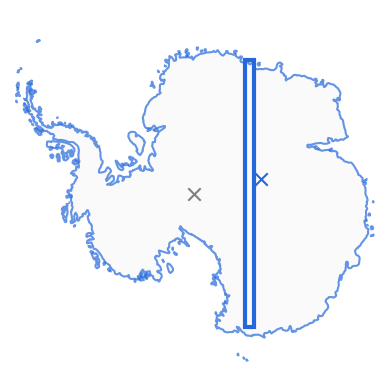

In [55]:
domain_vis(val256_y_min, val256_y_max, val256_x_min, val256_x_max)

In [57]:
def export_val256_images(bm_xr, d_y_min, d_y_max, d_x_min, d_x_max):

    val_bm_xr = bm_xr.sel(x = slice(d_x_min, d_x_max), 
                            y = slice(d_y_max, d_y_min))
    # Print to check dims
    print("Dimensions", val_bm_xr.dims)

    val_tensor = torch.tensor(val_bm_xr.bed.values).unsqueeze(0)

    IMAGE_DIM = 256
    N_ROW_IMAGES = int(val_bm_xr.bed.values.shape[0]/IMAGE_DIM)
    N_COLUMN_IMAGES = int(val_bm_xr.bed.values.shape[1]/IMAGE_DIM)

    image_tensor = torch.empty(size = (0, 1, IMAGE_DIM, IMAGE_DIM))

    for row in range(0, N_ROW_IMAGES):
        row_min = row * IMAGE_DIM
        row_max = row_min + IMAGE_DIM

        for column in range(0, N_COLUMN_IMAGES):
            column_min = column * IMAGE_DIM
            column_max = column_min + IMAGE_DIM

            image_tensor = torch.cat((image_tensor, val_tensor[:, row_min : row_max, column_min : column_max].unsqueeze(0)), dim = 0)

    min_values, _ = torch.min(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    max_values, _ = torch.max(image_tensor.reshape(image_tensor.shape[0], -1), dim = -1)
    range_values = max_values - min_values

    norm = torch.subtract(input = image_tensor.reshape(image_tensor.shape[0], -1), other = min_values.unsqueeze(1))
    norm = torch.div(input = norm, other = range_values.unsqueeze(1))
    norm = norm.reshape(image_tensor.shape)
    # Continuous and discretised to 755
    cont_765 = norm * (3*255)

    # Low qual (LQ/LR)
    pool = nn.AvgPool2d(4, stride = 4)
    cont_765_lq = pool(cont_765)
    
    rgb = cont_765_to_rgb(cont_765)
    rgb_lq = cont_765_to_rgb(cont_765_lq)

    n_images = rgb.shape[0]

    for i in range(n_images):
        # Create filename: string with contant length
        number = str(i)
        while(len(number) < 4):
            number = '0' + number

        name_hr = "datasets/ANT_val/ANT_val_HR_sub/" + number + ".png"
        # name_lr = "datasets/ANT_val/ANT_val_LR_sub/X4_sub/" + number + "x4" + ".png"
        name_lr = "datasets/ANT_val/ANT_val_LR_sub/X4_sub/" + number + ".png"

        # following https://data.vision.ee.ethz.ch/cvl/DIV2K/
        write_png(rgb[i, :, :, :].type(torch.uint8), filename = name_hr)
        write_png(rgb_lq[i, :, :, :].type(torch.uint8), filename = name_lr)

In [58]:
export_val256_images(bm_xr, val256_y_min, val256_y_max, val256_x_min, val256_x_max)

Dimensions Frozen({'x': 256, 'y': 8192})
